# Preliminary operations

## Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/Homework2

/content/gdrive/.shortcut-targets-by-id/18l1rfUZ0RyCJPiDTcoMfRf-FljJFv22e/Homework2


In [ ]:
!ls

'1. Data preparation.ipynb'   Ensamble.ipynb   original_dataset
'2. CNN.ipynb'		      hmw_2.ipynb      scalers
'2. CNN no scaler.ipynb'      hp	       Spettrogramma2.ipynb
 Attention.ipynb	      models	       Spettrogramma.ipynb
 Ensamble2.ipynb	      Notes.gdoc       training_dataset_homework2.zip


## Libraries and seed

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler,  StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.utils import  compute_class_weight
!pip install scikeras 
from scikeras.wrappers import KerasClassifier

import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from keras.layers import Layer
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

!pip install keras-tuner -q
import keras_tuner

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 20.9 MB/s 
     |████████████████████████████████| 1.6 MB 60.1 MB/s 
2.9.2


In [ ]:
!pip install scikit-optimize
from skopt import BayesSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 9.2 MB/s 


## Functions definition

In [ ]:
def data_processing(data, target):

  X_train_val, X_test, y_train_val, y_test = train_test_split(data, target, test_size = 0.1, random_state=seed, stratify=target)
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.1, random_state=seed, stratify=y_train_val)

  scaler = RobustScaler()
  scaler = scaler.fit(X_train.reshape(-1, X_train.shape[-1]))
  pickle.dump(scaler, open('scalers/robustscaler.sav', 'wb'))

  ss = pickle.load(open('scalers/robustscaler.sav', 'rb'))
  X_train_scaled = ss.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
  X_val_scaled = ss.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
  X_test_scaled = ss.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

  y_train_cat = tf.keras.utils.to_categorical(y_train)
  y_val_cat = tf.keras.utils.to_categorical(y_val)
  y_test_cat = tf.keras.utils.to_categorical(y_test)

  print(X_train_scaled.shape, y_train.shape, y_train_cat.shape)
  print(X_val_scaled.shape, y_val.shape, y_val_cat.shape)
  print(X_test_scaled.shape, y_test.shape, y_test_cat.shape)


  return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_train_cat, y_val_cat, y_test_cat

In [ ]:
def evaluate_model_f(file_name, test_set, target, labels):

  """ Function used to evaluate model's performances on the local test set, display of confusion matrix """
  """ Loading model from file """
  
  model = tfk.models.load_model(file_name)
  predictions = model.predict(test_set)
  metrics= {
    "model": file_name,
    "predictions" : predictions,
    "target": target,
    "cm": confusion_matrix(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), normalize='true', ),
    "accuracy" : accuracy_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1)),
    "precision" : precision_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "recall" : recall_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "f1" : f1_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro')  }
  
  print("Model: "+ str(metrics["model"]))
  print("Accuracy: "+ str(metrics["accuracy"]))
  print("F1 score: "+ str(metrics["f1"]))
  cm = metrics["cm"]
  plt.figure(figsize=(10,8))
  sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=list(labels.values()), yticklabels=list(labels.values()))
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  return metrics

In [ ]:
def evaluate_model_m(model, test_set, target, labels):

  """ Function used to evaluate model's performances on the local test set, display of confusion matrix """
  """ Loading model from trained model variable """
  
  predictions = model.predict(test_set)
  metrics= {
    "predictions" : predictions,
    "target": target,
    "cm": confusion_matrix(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), normalize='true', ),
    "accuracy" : accuracy_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1)),
    "precision" : precision_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "recall" : recall_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "f1" : f1_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro')  }
  
  print("Accuracy: "+ str(metrics["accuracy"]))
  print("F1 score: "+ str(metrics["f1"]))
  cm = metrics["cm"]
  plt.figure(figsize=(15,15))
  sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=list(labels.values()), yticklabels=list(labels.values()))
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  return metrics

# Data preparation
In this section we set up the datasets to be used in the next steps. We performed a traditional split as summarized below and we analysed the performance of multiple preprocessing techniques.

```
Time series:
  n. observations: 2429
  observation's length: 36 samples
  n. channel per observation: 6

Number of classes: 12
```



```
                   Dataset
                   |     |
      Training (0.9)    Test (0.1)
       |          |
Train (0.9)    Validation (0.1)
```



In [ ]:
data = np.load('original_dataset/x_train.npy')
target = np.load('original_dataset/y_train.npy')
print(data.shape)
print(target.shape)

(2429, 36, 6)
(2429,)


In [ ]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, y_train_cat, y_val_cat, y_test_cat= data_processing(data, target)

(1967, 36, 6) (1967,) (1967, 12)
(219, 36, 6) (219,) (219, 12)
(243, 36, 6) (243,) (243, 12)


In [ ]:
classes = {
    0: "Wish",
    1: "Another",
    2: "Comfortably",
    3: "Money",
    4: "Breathe",
    5: "Time",
    6: "Brain",
    7: "Echoes",
    8: "Wearing",
    9: "Sorrow",
    10: "Hey",
    11: "Shine"
}

# LSTM with Attention
In this section we defined, trained and evaluated an architecture including 2 bidirectional LSTMs, an Attention layer and a fully connected top for classification (whose parameters were established starting from the hyperparameter tuning and then fine tuned by trial and error) . 

At the end of the section, we analysed the results compared with the class distribution, looking for correlation among underrepresented classes and low scores. Surprisingly, it wasn't always the case that the worst performances occurred on the least represented classes. 

In [ ]:
X_train = X_train_scaled
y_train_l = y_train
y_train = y_train_cat
X_val = X_val_scaled
y_val = y_val_cat
X_test = X_test_scaled
y_test = y_test_cat
input_shape = X_train.shape[1:]
n_output = y_train.shape[-1]

batch_size= 128
epochs= 200

print(input_shape)
print(n_output)

(36, 6)
12


In [ ]:
class my_Attention(tf.keras.Model):
    def __init__(self, units):
        super(my_Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [ ]:
def build_BiLSTM_classifier(dp_rate1=0.3, dp_rate2=0.3, dp_rate3=0.3, dp_rate4=0.3, n1=128, n2=128, nc=512, na=10, elastic_lambda= 1e-3,  lr = 1e-3):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm0 = tfkl.Bidirectional(tfkl.LSTM(n1,activation='tanh',dropout=dp_rate1, return_sequences=True), name="bi_lstm_0")(input_layer)
    (lstm1, forward_h, forward_c, backward_h, backward_c) = tfkl.Bidirectional(tfkl.LSTM(n2,dropout=dp_rate2, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm0)

    state_h = tfkl.Concatenate()([forward_h, backward_h])
    state_c = tfkl.Concatenate()([forward_c, backward_c])

    (context_vector, attention_weights) = my_Attention(na)(lstm1, state_h)

    # Classifier
    cl = tfkl.Dense( 
        units=nc, 
        kernel_initializer = tfk.initializers.HeUniform(seed),
        kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda))(context_vector)
    cl=tfkl.LeakyReLU()(cl)
    cl = tfkl.Dropout(dp_rate4, seed=seed)(cl)  
    outputs = tfkl.Dense(
        n_output, 
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(seed))(cl)


    # Connect input and output through the Model class
    tl_model = tfk.Model(inputs=input_layer, outputs=outputs, name='model')
    tl_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(
        learning_rate=lr,
        rho=0.9,
        momentum=0.01,
        epsilon=1e-07),
      loss="categorical_crossentropy",
      metrics=["accuracy"],
      )
    return tl_model

In [ ]:
batch_size = 128
epochs = 200

model = build_BiLSTM_classifier(
    dp_rate1=0.2, 
    dp_rate2=0.25, 
    dp_rate3=0.3, 
    dp_rate4=0.4, 
    n1=200, 
    n2=348, 
    nc=458, 
    na= 50,
    elastic_lambda= 1e-5,  
    lr = 1e-3
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 36, 6)]      0           []                               
                                                                                                  
 bi_lstm_0 (Bidirectional)      (None, 36, 400)      331200      ['Input[0][0]']                  
                                                                                                  
 bi_lstm_1 (Bidirectional)      [(None, 36, 696),    2085216     ['bi_lstm_0[0][0]']              
                                 (None, 348),                                                     
                                 (None, 348),                                                     
                                 (None, 348),                                                 

In [ ]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data= (X_val, y_val),
    #class_weight = dict(zip(np.unique(y_train_l), compute_class_weight(class_weight = "balanced", classes = np.unique(y_train_l), y = y_train_l))),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-8)
    ]
).history

Epoch 1/200
16/16 [==============================] - 15s 303ms/step - loss: 2.0583 - accuracy: 0.3737 - val_loss: 1.7284 - val_accuracy: 0.4932 - lr: 0.0010
Epoch 2/200
16/16 [==============================] - 1s 56ms/step - loss: 1.5230 - accuracy: 0.5196 - val_loss: 1.4472 - val_accuracy: 0.5571 - lr: 0.0010
Epoch 3/200
16/16 [==============================] - 1s 46ms/step - loss: 1.3915 - accuracy: 0.5724 - val_loss: 1.6131 - val_accuracy: 0.4749 - lr: 0.0010
Epoch 4/200
16/16 [==============================] - 1s 44ms/step - loss: 1.3249 - accuracy: 0.5765 - val_loss: 1.4719 - val_accuracy: 0.5845 - lr: 0.0010
Epoch 5/200
16/16 [==============================] - 1s 40ms/step - loss: 1.2375 - accuracy: 0.6146 - val_loss: 1.3710 - val_accuracy: 0.5525 - lr: 0.0010
Epoch 6/200
16/16 [==============================] - 1s 41ms/step - loss: 1.2051 - accuracy: 0.6218 - val_loss: 1.2214 - val_accuracy: 0.6393 - lr: 0.0010
Epoch 7/200
16/16 [==============================] - 1s 46ms/step - 

In [ ]:
model.save('models/Attention5')

In [ ]:
att = tfk.models.load_model('models/Attention5')

62/62 [==============================] - 2s 11ms/step
Accuracy: 0.8617183528215556
F1 score: 0.8168085003484031


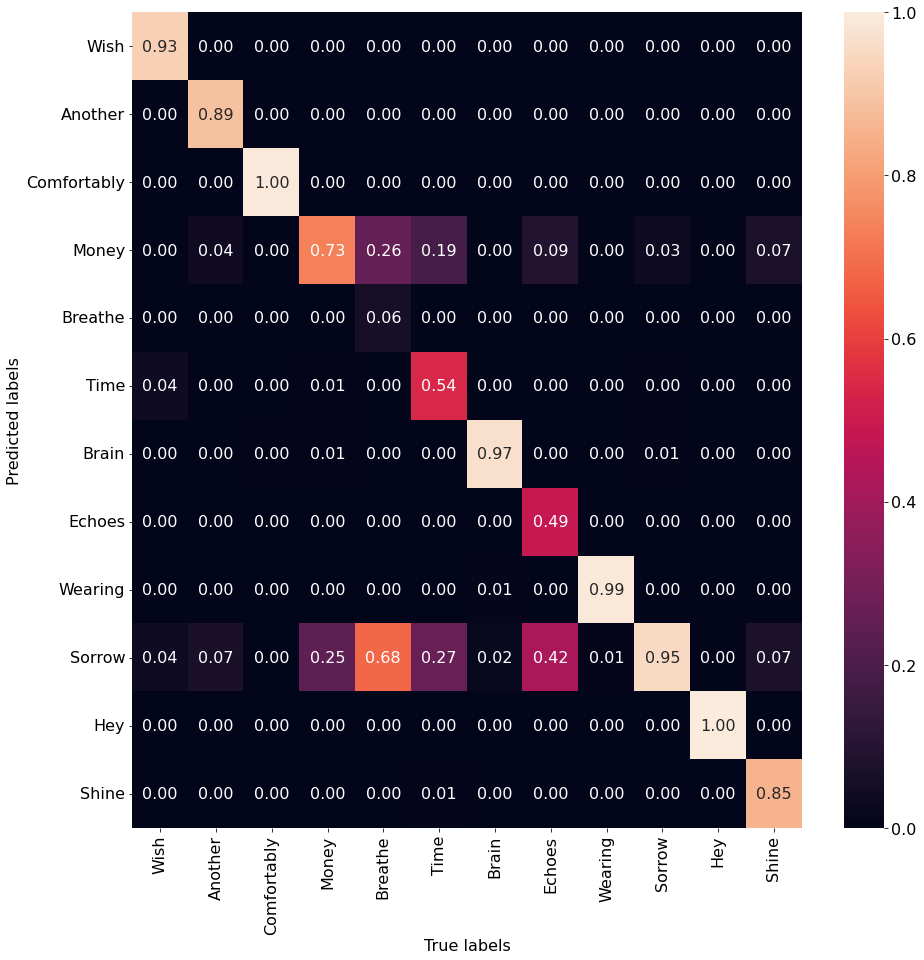

7/7 [==============================] - 0s 9ms/step
Accuracy: 0.7077625570776256
F1 score: 0.5857377191600853


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


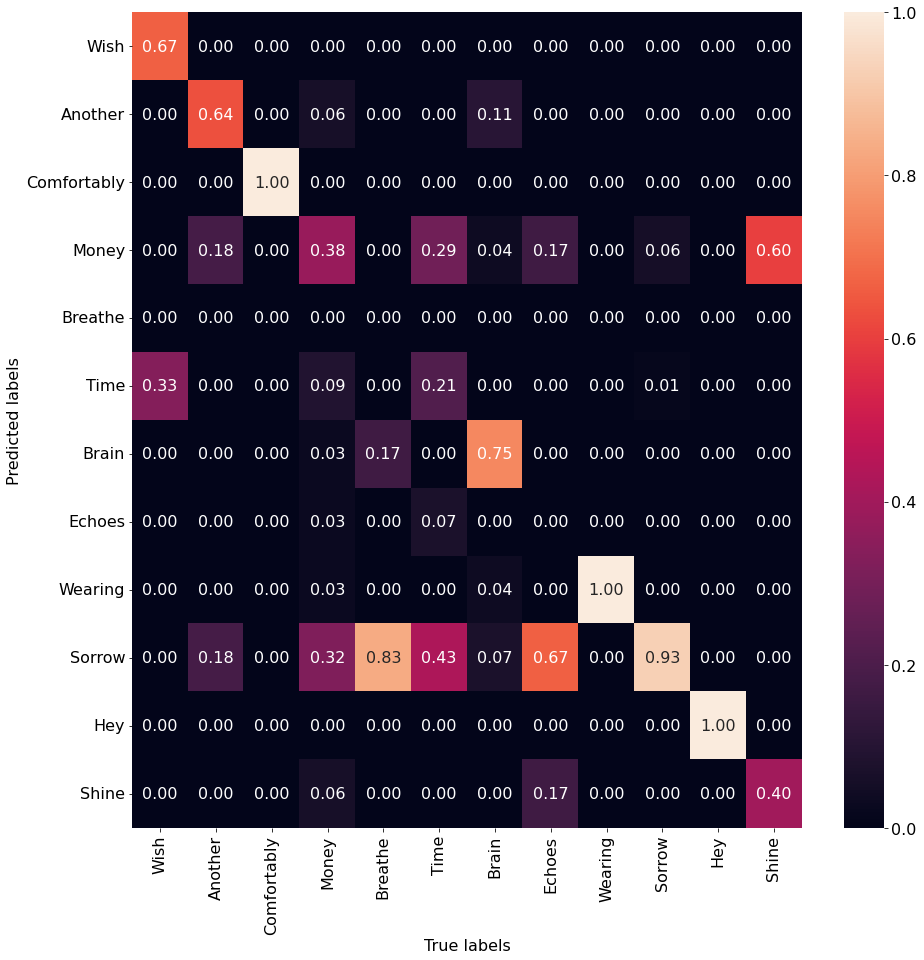

8/8 [==============================] - 0s 13ms/step
Accuracy: 0.6584362139917695
F1 score: 0.5650449020008403


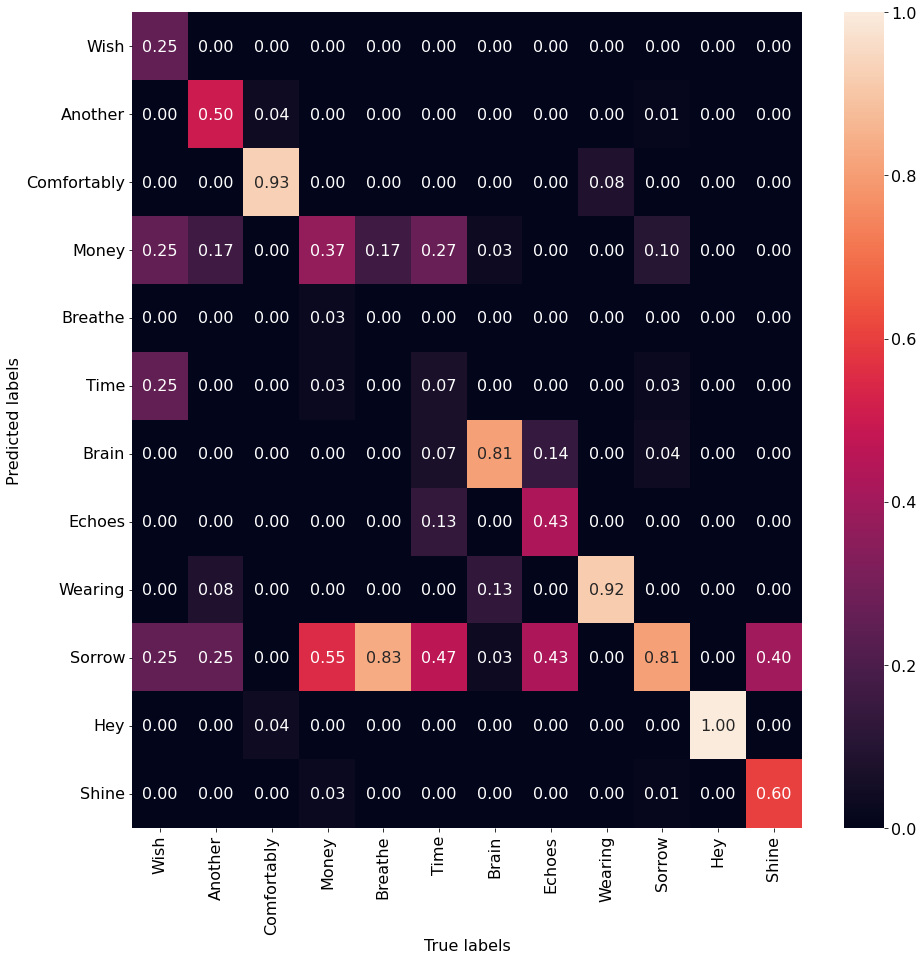

In [ ]:
ret = evaluate_model_m(att, X_train, y_train, classes)
ret = evaluate_model_m(att, X_val, y_val, classes)
ret = evaluate_model_m(att, X_test, y_test, classes)

In [ ]:
distr = pd.DataFrame(y_test).value_counts().sort_index().to_dict()
values= list(distr.values())
labels= list(classes.values())
results= np.diag(ret['cm'])
print(values)
print(labels)
print(results)

[5, 8, 78, 12, 7, 31, 15, 6, 38, 27, 12, 4]
['Wish', 'Another', 'Comfortably', 'Money', 'Breathe', 'Time', 'Brain', 'Echoes', 'Wearing', 'Sorrow', 'Hey', 'Shine']
[0.25       0.5        0.92592593 0.36842105 0.         0.06666667
 0.80645161 0.42857143 0.91666667 0.80769231 1.         0.6       ]


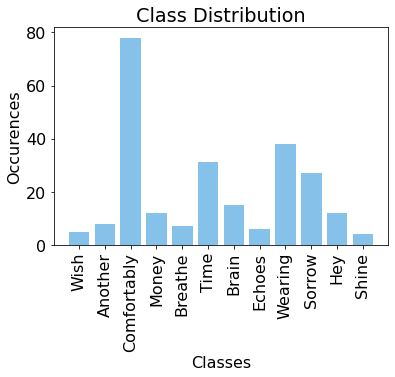

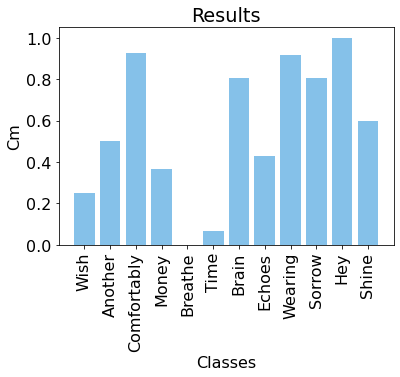

In [ ]:
plt.bar(x=labels,height=values, facecolor ='#85c1e9')
plt.title("Class Distribution", color = "black")
plt.tick_params(axis="both", colors = "black")
plt.xlabel("Classes", color = "black")
plt.ylabel("Occurences", color = "black")
plt.xticks(rotation=90)
plt.yticks
plt.show()

plt.bar(x=labels,height=results, facecolor ='#85c1e9')
plt.title("Results", color = "black")
plt.tick_params(axis="both", colors = "black")
plt.xlabel("Classes", color = "black")
plt.ylabel("Cm", color = "black")
plt.xticks(rotation=90)
plt.yticks
plt.show()

# GRU with Attention
In this section we defined, trained and evaluated an architecture including a bidirectional GRU, a bidirectional LSTM, an Attention layer  and a fully connected top for classification (whose parameters were established starting from the hyperparameter tuning and then fine tuned by trial and error). 

In [ ]:
def build_RNN_classifier_gru(dp_rate1=0.3, dp_rate2=0.3, dp_rate3=0.3, dp_rate4=0.3, n1=128, n2=128, nc=512, na=10, elastic_lambda= 1e-3,  lr = 1e-3):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm0 = tfkl.Bidirectional(tfkl.GRU(n1,activation='tanh',dropout=dp_rate1, return_sequences=True), name="bi_gru_0")(input_layer)
    (lstm1, forward_h, forward_c, backward_h, backward_c) = tfkl.Bidirectional(tfkl.LSTM(n2,dropout=dp_rate2, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm0)

    state_h = tfkl.Concatenate()([forward_h, backward_h])
    state_c = tfkl.Concatenate()([forward_c, backward_c])

    (context_vector, attention_weights) = my_Attention(na)(lstm1, state_h)

    # Classifier
    cl = tfkl.Dense( 
        units=nc, 
        kernel_initializer = tfk.initializers.HeUniform(seed),
        kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda))(context_vector)
    cl=tfkl.LeakyReLU()(cl)
    cl = tfkl.Dropout(dp_rate4, seed=seed)(cl)  
    outputs = tfkl.Dense(
        n_output, 
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(seed))(cl)


    # Connect input and output through the Model class
    tl_model = tfk.Model(inputs=input_layer, outputs=outputs, name='model')
    tl_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(
        learning_rate=lr,
        rho=0.9,
        momentum=0.01,
        epsilon=1e-07),
      loss="categorical_crossentropy",
      metrics=["accuracy"],
      )
    return tl_model

In [ ]:
batch_size = 128
epochs = 200

model = build_BiLSTM_classifier(
    dp_rate1=0.2, 
    dp_rate2=0.35, 
    dp_rate3=0.4, 
    dp_rate4=0.5, 
    n1=200, 
    n2=348, 
    nc=458, 
    na= 50,
    elastic_lambda= 1e-5,  
    lr = 1e-3
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 36, 6)]      0           []                               
                                                                                                  
 bi_gru_0 (Bidirectional)       (None, 36, 400)      249600      ['Input[0][0]']                  
                                                                                                  
 bi_lstm_1 (Bidirectional)      [(None, 36, 696),    2085216     ['bi_gru_0[0][0]']               
                                 (None, 348),                                                     
                                 (None, 348),                                                     
                                 (None, 348),                                                 

In [ ]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data= (X_val, y_val),
    #class_weight = dict(zip(np.unique(y_train_l), compute_class_weight(class_weight = "balanced", classes = np.unique(y_train_l), y = y_train_l))),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-8)
    ]
).history

Epoch 1/200
16/16 [==============================] - 7s 132ms/step - loss: 2.0060 - accuracy: 0.3915 - val_loss: 1.8391 - val_accuracy: 0.4018 - lr: 0.0010
Epoch 2/200
16/16 [==============================] - 1s 42ms/step - loss: 1.5442 - accuracy: 0.5231 - val_loss: 1.4664 - val_accuracy: 0.5388 - lr: 0.0010
Epoch 3/200
16/16 [==============================] - 1s 42ms/step - loss: 1.4118 - accuracy: 0.5623 - val_loss: 1.6074 - val_accuracy: 0.4703 - lr: 0.0010
Epoch 4/200
16/16 [==============================] - 1s 43ms/step - loss: 1.3535 - accuracy: 0.5714 - val_loss: 1.4997 - val_accuracy: 0.5753 - lr: 0.0010
Epoch 5/200
16/16 [==============================] - 1s 42ms/step - loss: 1.2853 - accuracy: 0.6024 - val_loss: 1.3102 - val_accuracy: 0.5479 - lr: 0.0010
Epoch 6/200
16/16 [==============================] - 1s 42ms/step - loss: 1.2090 - accuracy: 0.6329 - val_loss: 1.3292 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 7/200
16/16 [==============================] - 1s 41ms/step - l

In [ ]:
model.save('models/AttentionGRU2')

In [ ]:
att = tfk.models.load_model('models/AttentionGRU2')

62/62 [==============================] - 2s 10ms/step
Accuracy: 0.8998474834773768
F1 score: 0.8657632337629354


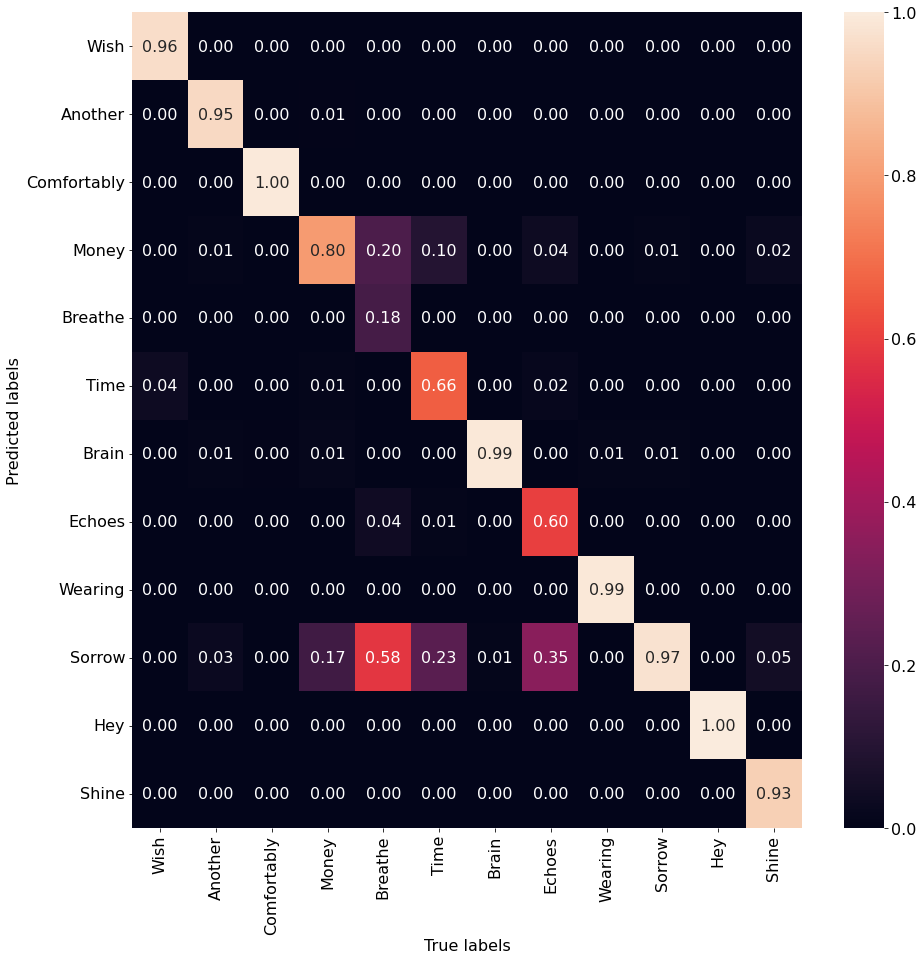

7/7 [==============================] - 0s 10ms/step
Accuracy: 0.6940639269406392
F1 score: 0.562941344806237


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


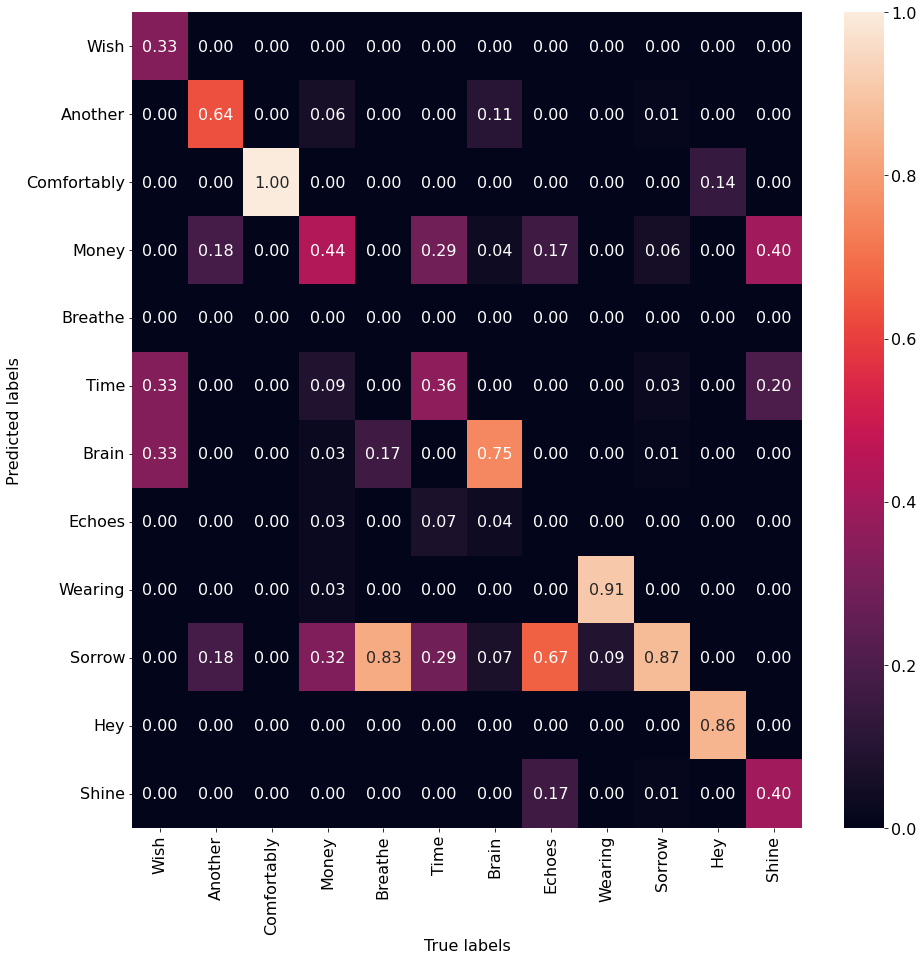

8/8 [==============================] - 0s 13ms/step
Accuracy: 0.6666666666666666
F1 score: 0.5703994401456906


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


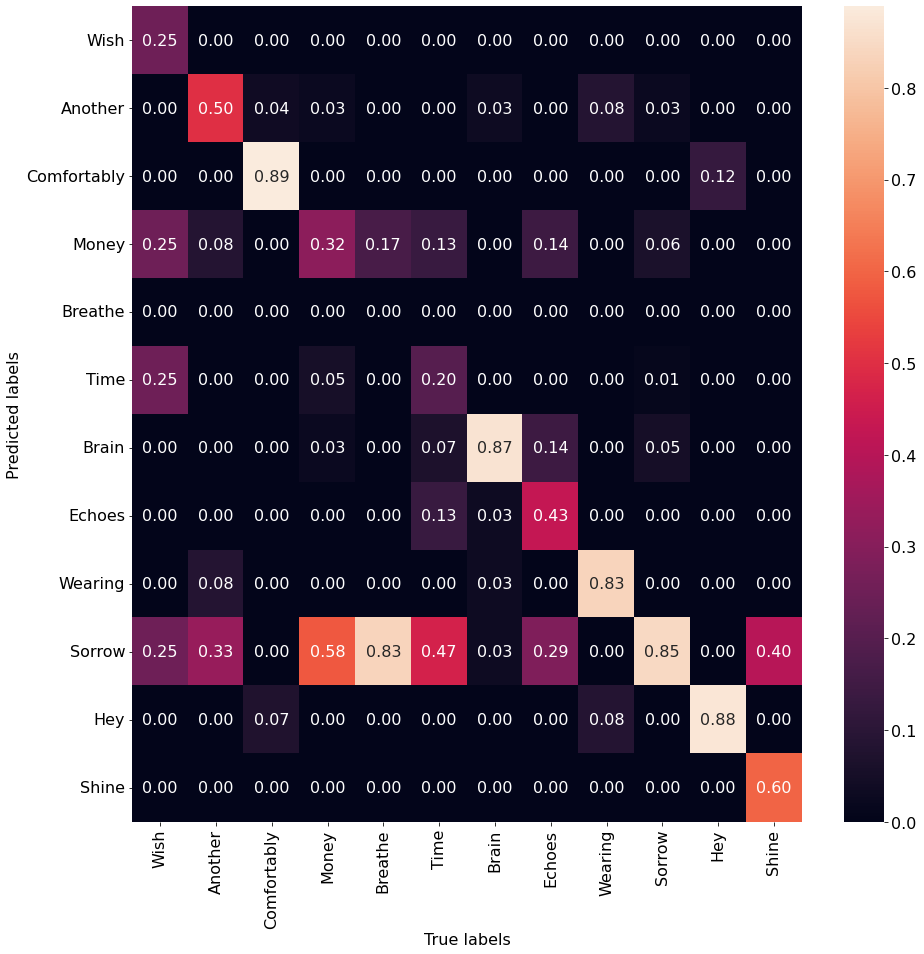

In [ ]:
ret = evaluate_model_m(att, X_train, y_train, classes)
ret = evaluate_model_m(att, X_val, y_val, classes)
ret = evaluate_model_m(att, X_test, y_test, classes)

# Ensemble
Finally, starting from the assumption that each model might have learned something that the other ones couldn't grasp, we defined an ensamble architecture to exploit the performance of the 3 best models obtained so far. The number of models and the specific architectures to be included in the ensemble have been tuned by trial and error. 

In [ ]:
input_shape = X_train.shape[1:]
n_output = y_train.shape[-1]

batch_size= 128
epochs= 200

print(input_shape)
print(n_output)

(36, 6)
12


In [ ]:
model1 = tfk.models.load_model('models/Attention5')
model2 = tfk.models.load_model('models/Effnet4')
model3 = tfk.models.load_model('models/AttentionGRU2')

In [ ]:
def ensemble(models, model_input):
    
    model_outputs=[]
    for i in range(len(models)):
      model= models[i]
      model._name="model" + str(i)
      model_outputs.append(model(model_input))
    
    ensemble_output = tfkl.Average()(model_outputs)
    ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
    
    return ensemble_model

In [ ]:
inputs = tfk.Input(shape=(36,6))
ens_123 = ensemble([model1,model2,model3],inputs)

In [ ]:
ens_123.save('models/Ens123')

In [ ]:
# Evaluate Ensemble123
m = ens_123
ret = evaluate_model_m(m, X_train, y_train, classes)
ret = evaluate_model_m(m, X_val, y_val, classes)
ret = evaluate_model_m(m, X_test, y_test, classes)

#Result: 0.953 (train), 0.744 (val), 0.716 (test)